## Setting up ...

As usual, we start by importing dependencies and registering `RandomAcccessibleInterval` notebook renderer.

In [2]:
//| code-fold: true

%mavenRepo scijava.public https://maven.scijava.org/content/groups/public
%maven net.imglib2:imglib2-algorithm:0.17.1-SNAPSHOT
%maven net.imglib2:imglib2-ij:2.0.3
%maven sc.fiji:bigdataviewer-core:10.6.2
%maven org.janelia.saalfeldlab:n5:3.3.0

In [3]:
//| code-fold: true

import io.github.spencerpark.jupyter.kernel.display.common.*;
import io.github.spencerpark.jupyter.kernel.display.mime.*;
import net.imglib2.img.display.imagej.ImageJFunctions;
import net.imglib2.RandomAccessibleInterval;

getKernelInstance().getRenderer().createRegistration(RandomAccessibleInterval.class)
    .preferring(MIMEType.IMAGE_PNG)
    .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
    .register((rai, context) -> Image.renderImage(
        ImageJFunctions.wrap(rai, rai.toString()).getBufferedImage(),
        context));

## Introduction

The ImgLib2 "**blocks**" API is about performing computations on blocks of
(image) data more efficiently than going pixel-by-pixel using `RandomAccess`,
`Type`, etc.

A fundamental limitation of this framework is that it *only works with
`NativeType`, and (so far) only with those that map 1:1 to primitives*. For
example, `UnsignedByteType` works, but `ComplexDoubleType` does not.

### Idea

The idea is simple:

1. Efficiently extract a region from a `RandomAccessible<T>` into a flat
   primitive array.
   
3. Implement small, efficient functions that compute the output flat primitive
   array from the input flat primitive array. (Importantly, these functions don't
   do anything "clever": out-of-bounds extension is handled outside; if the input
   data requires padding, assume the input array is padded. No per-element type
   checks, etc. If the function should work on `float[]` and `int[]` inputs, we
   have two versions.)

4. Wrap and assemble the computed flat primitive arrays back into
   `RandomAccessibleInterval`.

We also provide some infrastructure for chaining intermediate 'block'
operations.


### Outline

There are two levels of API:

1. The low-level `PrimitiveBlocks` and `BlockProcessor` deal with primitive java arrays.
2. The high-level `BlockSupplier` and `UnaryBlockOperator` wrap this in a layer of syntactic sugar and type-safety.

We look into the low-level API first. You'll never have to use it unless you want to implement a new "blocks" algorithm, but it is useful to illustrate whats happening.


## PrimitiveBlocks

Load and show 2D image that we will to work with...

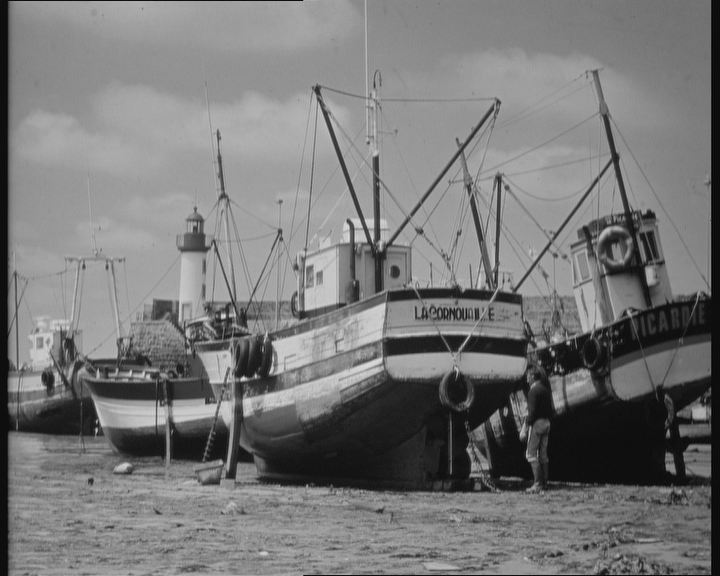

7e98c34d-337f-40e9-be85-5785b55cc957

In [4]:
import ij.IJ;
import net.imglib2.*;
import net.imglib2.util.*;
import net.imglib2.position.*;
import net.imglib2.img.array.*;
import net.imglib2.type.numeric.real.*;
import net.imglib2.type.numeric.integer.*;
import net.imglib2.converter.RealTypeConverters;
import net.imglib2.img.display.imagej.ImageJFunctions;

// var fn = "/Users/pietzsch/workspace/data/DrosophilaWing.tif";
// var fn = "https://mirror.imagej.net/ij/images/boats.gif";
var fn = "boats.gif";
RandomAccessibleInterval<UnsignedByteType> img = ImageJFunctions.wrap(IJ.openImage(fn));

display(img);

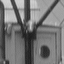

538fcb21-c913-41fa-9299-0409b329531f

In [5]:
var crop = Intervals.createMinSize(350, 220, 64, 64);
var cropped = img.view().interval(crop).zeroMin();
display(cropped);

For any `RandomAccessible<T>` we can get a "block copier" using `PrimitiveBlocks.of(...)`.
As mentioned above, this only works with `NativeType` that map 1:1 to primitives.

So let's get access to the blocks of our `img`:

In [6]:
import net.imglib2.blocks.PrimitiveBlocks;

PrimitiveBlocks<UnsignedByteType> blocks = PrimitiveBlocks.of(img);

We can now extract data into a primitive array (`byte[]` for our `UnsignedByteType` image).
We extract the top 4x4 pixels of the cropped area:

In [7]:
int[] pos = {350, 220};
int[] size = {4, 4};
byte[] array = new byte[4 * 4];
blocks.copy(pos, array, size);

Arrays.toString(array)

[119, -76, -55, -50, 83, -119, -69, -51, 67, 86, -116, -58, 63, 72, 95, -81]

Why are there negative numbers? Because we use Java's (signed) `byte` to represent `UnsignedByteType` values.

Let's convert to `IntType` and extract a `int[]` block instead.

In [8]:
RandomAccessibleInterval<IntType> converted = RealTypeConverters.convert(img, new IntType());

PrimitiveBlocks<IntType> blocks = PrimitiveBlocks.of(converted);
int[] array = new int[4 * 4];
blocks.copy(pos, array, size);

Arrays.toString(array)

[119, 180, 201, 206, 83, 137, 187, 205, 67, 86, 140, 198, 63, 72, 95, 175]

Note that `PrimitiveBlocks.of(...)` understood the virtual type conversion.

It also understands many virtual coordinate transforms.

In [9]:
var croppedAndConverted = img.view()
    .interval(crop)
    .zeroMin()
    .convert(IntType::new, (b,i) -> i.set(b.get()));

PrimitiveBlocks<IntType> blocks = PrimitiveBlocks.of(croppedAndConverted);
int[] pos = {0, 0};
int[] array = new int[4 * 4];
blocks.copy(pos, array, size);

Arrays.toString(array)

[119, 180, 201, 206, 83, 137, 187, 205, 67, 86, 140, 198, 63, 72, 95, 175]

(Note that we copy starting from `(0, 0)` now, as the shift to `(350, 220)` 
happens in the View transform.)

When `PrimitiveBlocks.of(...)` "understands" a `View` construction that ultimately end in CellImg, ArrayImg, etc., it and will create an optimized copier: Instead of using `RandomAccess` that checks for every pixel whether it enters a new `Cell`, whether it is out-of-bounds, etc., all these checks are precomputed and then relevant data from each `Cell` is copied in one go.

#### Details, details...

The speedup can be dramatic, in particular if the underlying source data is in a `CellImg`.
<br>
Here is for example results of [`CopyBenchmarkViewPrimitiveBlocks`](https://github.com/imglib/imglib2/blob/1fd92e5385127f25d27695771f001810c6e11109/src/test/java/net/imglib2/blocks/CopyBenchmarkViewPrimitiveBlocks.java)
```
# JMH version: 1.35
# VM version: JDK 17.0.3, OpenJDK 64-Bit Server VM, 17.0.3+7-LTS
...

Benchmark                                                  (oob)  (permute)  Mode  Cnt   Score   Error  Units
CopyBenchmarkViewPrimitiveBlocks.benchmarkLoopBuilder       true       true  avgt    5  12,789 ± 0,285  ms/op
CopyBenchmarkViewPrimitiveBlocks.benchmarkLoopBuilder       true      false  avgt    5   9,682 ± 0,152  ms/op
CopyBenchmarkViewPrimitiveBlocks.benchmarkLoopBuilder      false       true  avgt    5  14,333 ± 0,099  ms/op
CopyBenchmarkViewPrimitiveBlocks.benchmarkLoopBuilder      false      false  avgt    5  12,721 ± 0,123  ms/op
CopyBenchmarkViewPrimitiveBlocks.benchmarkPrimitiveBlocks   true       true  avgt    5   0,541 ± 0,010  ms/op
CopyBenchmarkViewPrimitiveBlocks.benchmarkPrimitiveBlocks   true      false  avgt    5   0,315 ± 0,024  ms/op
CopyBenchmarkViewPrimitiveBlocks.benchmarkPrimitiveBlocks  false       true  avgt    5   0,570 ± 0,013  ms/op
CopyBenchmarkViewPrimitiveBlocks.benchmarkPrimitiveBlocks  false      false  avgt    5   0,322 ± 0,008  ms/op
```

If a source `RandomAccessible` cannot be understood, `PrimitiveBlocks.of(...)` will return a fall-back implementation (based on `LoopBuilder`).
<br>
With the optional `OnFallback` argument of `PrimitiveBlocks.of(...)` it can be configured whether fall-back should be
* silently accepted (`ACCEPT`),
* a warning should be printed (`WARN`) -- the default,
* or an `IllegalArgumentException` thrown (`FAIL`).
The warning/exception message explains why the source `RandomAccessible` requires fall-back.

In [10]:
RandomAccessible<UnsignedByteType> func = new FunctionRandomAccessible<>(
        2,
		(pos, value) -> value.set((int) (pos.getIntPosition(0) * pos.getIntPosition(1))),
		UnsignedByteType::new);

PrimitiveBlocks<UnsignedByteType> blocks = PrimitiveBlocks.of(func);
int[] pos = {1, 1};
byte[] array = new byte[4 * 4];
blocks.copy(pos, array, size);

Arrays.toString(array)

The RandomAccessible net.imglib2.position.FunctionRandomAccessible@481d91cf is only be supported through the fall-back implementation of PrimitiveBlocks. 
Cannot analyze view net.imglib2.position.FunctionRandomAccessible@481d91cf of class FunctionRandomAccessible


[1, 2, 3, 4, 2, 4, 6, 8, 3, 6, 9, 12, 4, 8, 12, 16]

## BlockProcessor

Once we can extract primitive arrays from `RandomAccessibleInterval`, the actual computation happens in `BlockProcessor`.

This happens in two steps:
1. **Backward:** Inverse-transform the desired target interval to determine which source data we need to provide to the `BlockProcessor`.
2. **Forward:** Push the source data through the BlockProcessor to compute the target data (both primitive arrays).

To try that, we'll use a `BlockProcessor` for 2x downsampling. Normally we don't use `BlockProcessor` directly, so the constructor of that one is not `public`. We need to extract it from a high-level operator (explained later):

In [11]:
import net.imglib2.algorithm.blocks.*;
import net.imglib2.algorithm.blocks.downsample.Downsample;

BlockProcessor<byte[], byte[]> processor = Downsample
                .createOperator(new UnsignedByteType(), ComputationType.FLOAT, Downsample.Offset.HALF_PIXEL, 2)
                .blockProcessor();

#### 1. Backward: Inverse-transform the desired target interval to determine which source data we need to provide to the `BlockProcessor`.

Now we can ask the `processor` which source interval we will need to produce a
given target interval. (In this case, the source interval is 2x larger and
appropriately shifted for downsampling).

In [12]:
Interval interval = Intervals.createMinSize(200, 100, 64, 64);
System.out.println("target interval = " + Intervals.toString(interval));

processor.setTargetInterval(interval);
System.out.println("source interval = " + Intervals.toString(processor.getSourceInterval()));

target interval = [(200, 100) -- (263, 163) = 64x64]
source interval = [(400, 200) -- (527, 327) = 128x128]


#### 2. Forward: Push the source data through the BlockProcessor to compute the target data (both primitive arrays).

We first need to provide some source data for processing.
We get that via `PrimitiveBlocks.copy(...)`, where we specify the source pos/size as the source interval obtained from `processor`.
(We can also ask `processor` to allocate a primitive array for holding the input data.)

In [13]:
byte[] sourceData = new byte[128 * 128]; // processor.getSourceBuffer();
PrimitiveBlocks.of(img).copy(processor.getSourcePos(), sourceData, processor.getSourceSize());

 We allocate a primitive array to hold the result, then call `BlockProcessor.compute(...)`. 
 

In [14]:
byte[] targetData = new byte[64 * 64];
processor.compute(sourceData, targetData);

Finally, we show the result wrapped as an `ArrayImg`, as well as the source area it was obtained from.

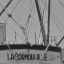

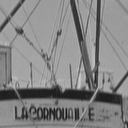

ffcefbd4-29bb-4a09-8d3e-8b5ff6ceba38

In [15]:
var downsampled = ArrayImgs.unsignedBytes(targetData, 64, 64);
display(downsampled);
display(img.view().interval(processor.getSourceInterval()));

As you can imagine, it is straightforward to chain `BlockProcessor`s, sending the target interval backwards through the chain, and the source data forwards via approriate temporary intermediate arrays.
In fact, our `BlockProcessor` is already such a concatenation (convert `byte[]` to `float[]`, downsample `float[]` to `float[]`, convert `float[]` to `byte[]`).

In [16]:
System.out.println(processor.getClass());

class net.imglib2.algorithm.blocks.ConcatenatedBlockProcessor


## BlockSupplier and UnaryBlockOperator

With the details out of the way, let's look at how this is wrapped into a more
ImgLib2-like API.

The `BlockSupplier` interface is more or less equivalent to `PrimitiveBlocks`.
The above code works fine if you replace `PrimitiveBlocks` with `BlockSupplier`.

`BlockSupplier` provides additional default methods for chaining operations, and
support for wrapping into a `CachedCellImg`, etc. This is not available in
imglib2 core, where `PrimitiveBlocks` lives, therefore the duplication...
(`BlockSupplier` lives in imglib2-algorithm.)

In [17]:
BlockSupplier<UnsignedByteType> blocks = BlockSupplier.of(img);

The `UnaryBlockOperator<S,T>` interface wraps `BlockProcessor<I,O>`.
The generic parameters `<S,T>` are the ImgLib2 Types corresponding to the primitive array types `<I,O>`.

Here is the downsampling operator we already used above:

In [18]:
UnaryBlockOperator<UnsignedByteType, UnsignedByteType> operator =
        Downsample.createOperator(new UnsignedByteType(), ComputationType.FLOAT, Downsample.Offset.HALF_PIXEL, 2);

### Chaining operators

`UnaryBlockOperator` knows the dimensionality of its source and target spaces as well as its source and target Types.
So does `BlockSupplier`.

In [19]:
System.out.println("blocks.numDimensions   = " + blocks.numDimensions());
System.out.println("blocks.type            = " + blocks.getType().getClass().getSimpleName());
System.out.println("op.numSourceDimensions = " + operator.numSourceDimensions());
System.out.println("op.sourceType          = " + operator.getSourceType().getClass().getSimpleName());
System.out.println("op.numTargetDimensions = " + operator.numTargetDimensions());
System.out.println("op.targetType          = " + operator.getTargetType().getClass().getSimpleName());

blocks.numDimensions   = 2
blocks.type            = UnsignedByteType
op.numSourceDimensions = 2
op.sourceType          = UnsignedByteType
op.numTargetDimensions = 2
op.targetType          = UnsignedByteType


This allows for type-safe (at compile-time) and "dimensionality-safe" (at runtime) concatenation.

Concatenating two `UnaryBlockOperator`s yields a new `UnaryBlockOperator`.<br>
Concatenating a `BlockSupplier` and a `UnaryBlockOperator`s yields a new `BlockSupplier`.

In [20]:
BlockSupplier<UnsignedByteType> blocks = BlockSupplier.of(img);
UnaryBlockOperator<UnsignedByteType, UnsignedByteType> operator =
        Downsample.createOperator(new UnsignedByteType(), ComputationType.FLOAT, Downsample.Offset.HALF_PIXEL, 2);

BlockSupplier<UnsignedByteType> concatenation = blocks.andThen(operator);

Note, that creating the operator we had to specify source type (`new UnsignedByteType()` and number of source dimensions (`2`).
These must match those of `blocks`, so we could also directly get them from the thing we are concatenating to.

To avoid this duplication, `BlockSupplier.andThen(...)` also accepts operator factory functions.

In [21]:
BlockSupplier<UnsignedByteType> blocks = BlockSupplier.of(img);
long[] size = img.dimensionsAsLongArray();

Try to run the following cell multiple times...

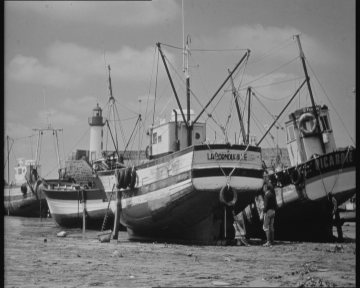

f60edb17-f1f4-41a8-ab31-80e76d09010b

In [22]:
blocks = blocks.andThen(
    Downsample.downsample(ComputationType.FLOAT, Downsample.Offset.HALF_PIXEL));
size = Downsample.getDownsampledDimensions(size);

byte[] data = new byte[(int)(size[0] * size[1])];
blocks.copy(new long[] {0,0}, data, Util.long2int(size));
display(ArrayImgs.unsignedBytes(data, size));

### Wrap as CellImg

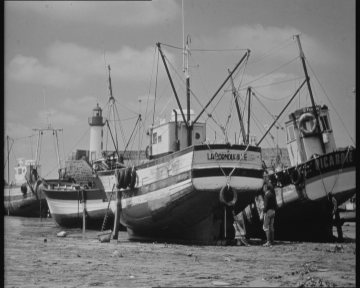

ddfa2dc5-8cdf-4096-949b-803796f704ac

In [23]:
RandomAccessibleInterval<UnsignedByteType> cellImg = blocks.toCellImg(size, 64);
display(cellImg);

### Process in Tiles

`BlockSupplier.tile(...)` splits the computation of a requested target interval into computations of sub-intervals of a specified (maximum) size. The results are stored into temporary buffers and then copied into the target primitive array.

Applications for this are:
* Computing large outputs (e. g. to write to N5 or wrap as ArrayImg) with operators that have better performance with smaller block sizes.
* Avoiding excessively large blocks (e. g. when chaining multiple downsampling operators).


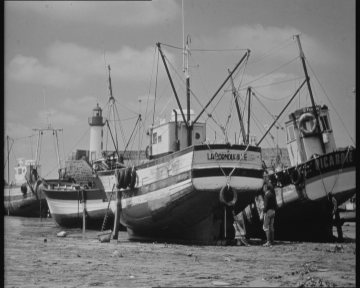

80954e64-fa18-4973-a1fd-dc8bd2c6b55d

In [24]:
blocks = blocks.tile(16);
blocks.copy(new long[] {0,0}, data, Util.long2int(size));
display(ArrayImgs.unsignedBytes(data, size));

## Advanced applications

In [ ]:
import net.imglib2.algorithm.blocks.convert.Convert;
import net.imglib2.algorithm.blocks.convolve.Convolve;
import net.imglib2.algorithm.blocks.downsample.Downsample;
import net.imglib2.algorithm.blocks.transform.Transform;
import bdv.util.*;
import static net.imglib2.view.fluent.RandomAccessibleIntervalView.Extension.*;

String fn = "e002_stack_fused-8bit.tif";
RandomAccessibleInterval<UnsignedByteType> img = ImageJFunctions.wrap(IJ.openImage(fn));
Bdv bdv = BdvFunctions.show(img, fn);
long[] size = img.dimensionsAsLongArray();

In [ ]:
import bdv.util.volatiles.VolatileViews;

RandomAccessibleInterval<FloatType> downsampledAndSmoothed = BlockSupplier
        .of(img.view().extend(mirrorDouble()))
        .andThen(Convert.convert(new FloatType()))
        .andThen(Convolve.gauss(3))
        .toCellImg(size, 32);
BdvSource source = BdvFunctions.show(VolatileViews.wrapAsVolatile(downsampledAndSmoothed), "downsampledAndSmoothed", Bdv.options().addTo(bdv));